# Data Prep


# Download datasets

`get_data.sh` prints commands that can download datasets and `parallel -j <n>` is used to parallelize downloads 

All the datasets are saved under `datasets` directory.

`datasets/<lang>-eng/mtdata.signature.txt` file flags as a succesful download. Delete these files to re-download.

Note: this is disk and network intensive task, so dont use too many parallel jobs ; 20 is a good limit

In [ ]:
%%bash

./get_data.sh  | parallel -j 20

/bin/sh: q: command not found


# Collect statistics

In [18]:
%%bash 
stats=dataset-stats.tsv 
[[ -f $stats ]] || {
    (printf "Lang\tSents\tXXX\tENG\tHeldout\n"
    for i in datasets/*; do
        lang=$(echo $i | cut -f2 -d/ | cut -f1 -d-)  # datasets/spa-eng -> spa
        stat1=$(wc -lw < $i/train.$lang | awk -v OFS='\t' '{print $1,$2}')
        stat2=$(wc -w < $i/train.eng)
        heldout=$(ls $i/tests/*.eng 2> /dev/null | wc -l )
        printf "$lang\t$stat1\t$stat2\t$heldout\n"
    done
    ) > $stats
}

In [4]:
import pandas as pd

In [ ]:
pd.read_csv('dataset-stats.tsv', sep='\t', header=0)

# Merge


In [22]:
%%bash
merged=merged

[[ -d $merged/tests ]] || mkdir -p $merged/tests
[[ -f $merged/train.raw.tsv ]] || (
    for i in datasets/*-eng; do
        lang=$(echo $i | awk -F '[/-]' '{print $2}')
        cp $i/tests/*.* $merged/tests 2> /dev/null
        paste <(zcat $i/train.meta.gz) $i/train.$lang $i/train.eng  | sed "s/^/$lang\t/" 
    done
) >  $merged/train.raw.tsv

In [2]:
!ls -lh merged/train.raw.tsv

-rw------- 1 tgowda G-819290 119G Jun  7 03:42 merged/train.raw.tsv


In [8]:
# smaleer file for development  with spark
!head -100000 merged/train.raw.tsv > merged/train-sample.raw.tsv
!wc -l merged/train-sample.raw.tsv
!head -2 merged/train-sample.raw.tsv

100000 merged/train-sample.raw.tsv
abk	JW300-abk_eng	Аҵакы	Table of Contents
abk	JW300-abk_eng	© 2016 Watch Tower Bible and Tract Society of Pennsylvania	© 2016 Watch Tower Bible and Tract Society of Pennsylvania


# Tokenize

Using PySpark -- on single node for now -- Use a node with many CPU cores.

I am using a node with 56 CPUs. 

TODO: learn how to setup multinode spark on slurm grid.  Looks like this has an answer https://serverfault.com/a/776688 

Note: Too many CPUs may not be that useful if storage/disk is the bottleneck. I am sticking with 56 CPUs on one node for now

In [1]:
from pyspark.sql import SparkSession
import pyspark
from functools import partial
from pathlib import Path
from sacremoses import MosesTokenizer, MosesPunctNormalizer
from html import unescape
import logging as log

SCHEMA = 'lang STRING, ds_name STRING, src STRING, eng STRING'
log.basicConfig(level=log.INFO)

In [3]:

normr = MosesPunctNormalizer(
        lang='en',
        norm_quote_commas=True,
        norm_numbers=True,
        pre_replace_unicode_punct=True,
        post_remove_control_chars=True,
    )
tok = MosesTokenizer(lang='en')

def tokenize_eng(text):
    try:
        text=unescape(text)
        text = normr.normalize(text)
        text = tok.tokenize(text, escape=False, return_str=True, aggressive_dash_splits=True,
            protected_patterns=tok.WEB_PROTECTED_PATTERNS)
        return text
    except:
        if text:
            return '<TOKERR> ' + text
        else:
            return ''

tokenize_src = tokenize_eng # using english ton source; not terrific, but not terrible either
print(tokenize_eng("This's cool-stuff...! http://isi.edu  @id #hashtag email@gmail.com and,this but oh.no  no... no."))
print(tokenize_src("मैं तुमसे प्यार करता हूँ!। चिल्लाईए मत।"))

This 's cool @-@ stuff ... ! http://isi.edu @id #hashtag email@gmail.com and , this but oh.no no ... no .
मैं तुमसे प्यार करता हूँ ! । चिल्लाईए मत ।


In [2]:

spark = SparkSession \
    .builder \
    .appName("SacreMoses Tokenizer on PySpark") \
    .config("spark.driver.memory", "120g") \
    .getOrCreate()
# I have a lot of mem, so 120g -- use all
spark

In [4]:
raw_file = 'merged/train.raw.tsv'
df = spark.read.csv(raw_file, sep='\t', schema='lang STRING, ds_name STRING, src STRING, eng STRING')


In [10]:
df_tok = df.rdd.map(lambda r: (r.lang, r.ds_name, tokenize_src(r.src), tokenize_eng(r.eng)))

In [11]:
def to_tsv(rec):
    return '\t'.join(col.replace('\t', ' ') for col in rec)

tok_file = raw_file.replace('.raw.tsv', '.tok.tsv')
print(f'saving at {tok_file}')
df_tok.map(to_tsv).saveAsTextFile(tok_file)

print("=== ALL DONE ===")

saving at merged/train.tok.tsv


# Learn length ratios


In [4]:
tok_file = 'merged/train.tok.tsv'
df_tok = spark.read.csv(tok_file, sep='\t', schema='lang STRING, ds_name STRING, src STRING, eng STRING')\
    .filter("ds_name != 'wiki_matrix_v1-tam_eng' and ds_name != 'wiki_matrix_v1-tel_eng'")
# there was an error processing wiki_matrix_v1; so exclude them

In [22]:
# are there tokenization errors ?
df_tok.rdd.filter(lambda rec: (rec.src and rec.src.startswith('<TOKERR>'))
                    or rec.eng and rec.eng.startswith('<TOKERR>'))\
    .count()

0

In [24]:
df_tok.take(2)

[Row(lang='fas', ds_name='OPUS_OpenSubtitles_v2018-fas_eng', src='خداحافظ .', eng='Bye .'),
 Row(lang='fas', ds_name='OPUS_OpenSubtitles_v2018-fas_eng', src='-خداحافظ .', eng='- Okay . Bye .')]

In [12]:
def map_lenghts(rec):
    t1 = rec.src.split() if rec.src else []
    t2 = rec.eng.split() if rec.eng else []
    return rec.lang, (len(t1), len(t2))

len_rdd = df_tok.rdd.map(map_lenghts).filter(lambda r: all(r[1]))\
    .persist(pyspark.StorageLevel.MEMORY_AND_DISK)
    # try to keep it in memory if there is room, or spill it to disk when there isn't! cool

len_ratio_rdd = len_rdd.map(lambda r: (r[0], r[1][0]/r[1][1]))  # lang, src_len/tgt_len


def compute_key_mean(rdd, precision=4):
    """Compute mean per key"""
    means = (rdd.mapValues(lambda v: (v, 1)) # (sum, count)
        .reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))   # merge: (s1, c1) + (s2, c2)
        .mapValues(lambda v: v[0]/v[1]) # mean=sum/count
        .collectAsMap())
    return {k: round(v, precision) for k, v in means.items()}
    
len_ratio_mean = compute_key_mean(len_ratio_rdd)
print(list(len_ratio_mean.items())[:20])

[('nyn', 0.9226), ('kbp', 1.251), ('cos', 1.0536), ('run', 0.9835), ('cab', 0.9893), ('kri', 1.3761), ('her', 1.1174), ('mlg', 1.1407), ('tam', 0.6691), ('vol', 0.8182), ('iku', 0.6667), ('kal', 0.6606), ('ssp', 1.0431), ('ada', 1.5334), ('kas', 1.3257), ('bam', 1.1071), ('ncs', 1.046), ('sfs', 0.9999), ('zib', 1.0025), ('urh', 1.1737)]


In [14]:
def deviation(rec):
    lang, ratio = rec
    return lang, (len_ratio_mean[lang] - ratio)**2

import math
len_ratio_std_sq = compute_key_mean(len_ratio_rdd.map(deviation))
len_ratio_std = {k: round(math.sqrt(v), 4) for k,v  in len_ratio_std_sq.items()}

print(list(len_ratio_std.items())[:20])

[('nyn', 0.3079), ('kbp', 0.5355), ('cos', 0.2394), ('run', 0.27), ('cab', 0.4219), ('kri', 0.5165), ('her', 0.3936), ('mlg', 0.3491), ('tam', 0.4057), ('vol', 0.1884), ('iku', 0.2973), ('kal', 0.3523), ('ssp', 0.3927), ('ada', 0.5846), ('kas', 0.8157), ('bam', 0.2625), ('ncs', 0.4005), ('sfs', 0.0), ('zib', 0.05), ('urh', 0.4894)]


In [15]:
import json
from json import encoder
from pathlib import Path

len_stats_file = 'lang-len-stats.json'
with open(len_stats_file, 'w') as wrt:
    data = {k: [round(mu, 4), round(len_ratio_std[k], 4)]
                     for k, mu in sorted(len_ratio_mean.items())}
    json.dump(data, wrt, indent=2, ensure_ascii=False)


In [23]:
for lang, (mu, std) in data.items():
    if not (1/4 < mu < 4 ) or std > 3:
        print(lang, mu, std)
# these  with high deviations look suspicious 

aka 2.279 9.0673
diq 1.1542 4.5901
dzo 4.1716 1.9121
gom 1.3054 3.1864
hrv 1.6678 3.4112
kbh 1.915 6.9033
min 1.1696 3.9325
mlt 1.5552 3.2189
pmy 2.6974 4.5689
sun 1.0056 5.3713
tcy 2.9183 18.7931
trv 1.5774 3.1875
vec 1.8151 3.0819


In [26]:
# random sample
from pyspark.sql.functions import rand 
df_tok.orderBy(rand()).take(5)

[Row(lang='fas', ds_name='OPUS_OpenSubtitles_v2018-fas_eng', src='... اگه فقط ميشد تو ورشو جشن بگيريم', eng='If we could only celebrate in Warsaw ...'),
 Row(lang='srp', ds_name='OPUS_OpenSubtitles_v2018-srp_eng', src='Kaže da zna da imamo tehnologiju Koja privremeno neutralizira njegove moæi', eng='He says he knows that we have a technology that can temporary neutralize his powers .'),
 Row(lang='dan', ds_name='EESC2017-dan_eng', src="According to the Commission 's assessment , the eligible additional expenditure amounted to 0.04 % of GDP in 2015 and currently no further incremental costs are expected in 2016 .", eng='Ifølge Kommissionens vurdering beløb de pågældende yderligere udgifter sig til 0,04 % af BNP i 2015 , og foreløbig forventes der ingen yderligere udgiftsforøgelse i 2016 .'),
 Row(lang='lit', ds_name='europarl_v10-lit_eng', src='Todėl neabejotinai teigiamai vertinu bendrą visos tarptautinės bendruomenės poziciją ir manau , kad turime ne tik palaikyti demokratiją ir išgel

In [30]:
%%time
def language_stats(len_rdd):
    return (len_rdd.mapValues(lambda v: (1, v[0], v[1]))  # sents, src_toks, eng_toks
            .reduceByKey(lambda a, b: tuple(x + y for x,y in zip(a, b)))   # merge
            .collectAsMap())

lang_stat = language_stats(len_rdd)
print(list(lang_stat.items())[:10])

[('nyn', (54338, 828671, 936243)), ('kbp', (31205, 633866, 534942)), ('cos', (150, 16413, 16130)), ('run', (401594, 6789820, 7104199)), ('cab', (62269, 1033783, 1113015)), ('kri', (44809, 1018780, 766080)), ('her', (8860, 155250, 145240)), ('mlg', (1132939, 24970173, 22425803)), ('tam', (756440, 6830955, 13505063)), ('vol', (2425, 21112, 24737))]
CPU times: user 81.6 ms, sys: 28.6 ms, total: 110 ms
Wall time: 23.2 s


In [33]:
stats_file = Path('lang-stats-tok.tsv')
with stats_file.open('w') as f:
    f.write("\t".join(["Lang", "Sents", "Source", "English"]) + '\n')
    for lang, (sents, src_toks, eng_toks) in lang_stat.items():
        f.write(f"{lang}\t{sents}\t{src_toks}\t{eng_toks}\n")
    print(f"Wrote {stats_file}")
    

Wrote lang-stats-tok.tsv


In [16]:
from matplotlib import pyplot as plt
import seaborn as sns


def simple_plot(names, series, legends, title='', save=None):
    assert len(series) == len(legends)
    fig, ax = plt.subplots(figsize=(20, 4))
    sers = []
    mn, mx = float('inf'), float('-inf')
    for ser, leg in zip(series, legends):
        sers.append(ax.plot(names, ser, 'o', label=leg)[0])
        mn, mx = min(mn, min(ser)), max(mx, max(ser))
    
    plt.ylim((mn/10, mx*10))
    plt.legend(sers, [s.get_label() for s in sers])
    plt.yscale('log')
    plt.xticks(rotation=90, fontsize=12)
    plt.tight_layout()
    plt.margins(x=0.01)
    plt.title(title)
    if save:
        print(f'saving to {save}')
        plt.savefig(save)
    plt.show()

def plot_lang_stats(stats, chunk_size=100, max_stats=500, saveas=None):
    names_all = list(sorted(stats.keys(), reverse=True, key=lambda l:lang_stat[l][2]))
    for start in range(0, min(max_stats, len(stats)), chunk_size):
        names = names_all[start:start+chunk_size]
        sents = [stats[n][0] for n in names]
        src_toks = [stats[n][1] for n in names]
        eng_toks = [stats[n][2] for n in names]
        save_chunk = None
        if saveas:
            assert len(saveas.split('.')) == 2 # only one dot allowed
            save_chunk = saveas.replace('.', f'-{start+1}.')
        sns.set(font="Serif", style='white',font_scale=1.1)
        simple_plot(names, series=[src_toks, eng_toks, sents], 
                    legends=['Source Tokens', 'English Tokens', 'Sentences'],
                    title=f'Languages {start}-{start+len(names)}',
                   save=save_chunk)

In [25]:
spark.stop()  # to stop spark

In [115]:
import re

class MyFilter:

    def __init__(self):
        self.min_len = 1
        self.max_len = 120
        self.len_ratio = 5
        self.max_word_len = 30
        self.remove_urls = True
        #self.stats = stats 

    
    def __call__(self, rec):
        lang, provenance, src, eng = rec
        if not src or not eng or not src.strip() or not eng.strip():
            return 'EMPTY'
        src, tgt = src.strip(), eng.strip()

        if src == eng:
            return 'COPY'

        src_toks = src.split()
        eng_toks = eng.split()
        
        if len(src_toks) < self.min_len or len(eng_toks) < self.min_len:
            return 'MIN_LEN'

        if len(src_toks) > self.max_len or len(eng_toks) > self.max_len:
            return 'MAX_LEN'

        if not (1/self.len_ratio <= len(src_toks)/len(eng_toks) <= self.len_ratio):
            return 'LEN_RATIO'
        
        if any(len(t) > self.max_word_len for t in src_toks)\
            or any(len(t) > self.max_word_len for t in eng_toks):
            return 'MAX_WORD_LEN'
        
        if 'http' in src or 'http' in eng:
            return 'HTTP'
        
        return None # no reason to drop

my_filter = MyFilter()

# good recs
def row_to_tsv(row):
    return f'{row.lang}\t{row.ds_name}\t{row.src}\t{row.eng}'
tok_good_file = 'merged/train.good.tok.tsv'
df_tok.rdd.filter(lambda row: not(my_filter(row))).map(row_to_tsv).saveAsTextFile(tok_good_file)


In [118]:
tok_bad_file = 'merged/train.bad.tok.tsv'
df_tok.rdd.filter(lambda row: my_filter(row))\
    .map(lambda row: my_filter(row) + '\t' + row_to_tsv(row))\
    .saveAsTextFile(tok_bad_file)
print("Saved " + tok_bad_file)

Saved merged/train.bad.tok.tsv


----

Stats of cleaned / good data

In [121]:
%%time
tok_good_file = 'merged/train.good.tok.tsv'
df_tok = spark.read.csv(tok_good_file, sep='\t', schema=SCHEMA)

# lang: sents, src_toks, tgt_toks
len_stats  = (df_tok.rdd.map(lambda r: (r.lang, (1, len(r.src.split()), len(r.eng.split())) ) )
        .reduceByKey(lambda a, b: tuple(x + y for x,y in zip(a, b)))   # merge
        .collectAsMap())

print(list(lang_stat.items())[:10])

[('nyn', (54338, 828671, 936243)), ('kbp', (31205, 633866, 534942)), ('cos', (150, 16413, 16130)), ('run', (401594, 6789820, 7104199)), ('cab', (62269, 1033783, 1113015)), ('kri', (44809, 1018780, 766080)), ('her', (8860, 155250, 145240)), ('mlg', (1132939, 24970173, 22425803)), ('tam', (756440, 6830955, 13505063)), ('vol', (2425, 21112, 24737))]
CPU times: user 100 ms, sys: 47.1 ms, total: 147 ms
Wall time: 3min 38s


In [122]:
stats_file = Path('lang-stats-tok-good.tsv')
with stats_file.open('w') as f:
    f.write("\t".join(["Lang", "Sents", "Source", "English"]) + '\n')
    for lang, (sents, src_toks, eng_toks) in lang_stat.items():
        f.write(f"{lang}\t{sents}\t{src_toks}\t{eng_toks}\n")
    print(f"Wrote {stats_file}")

Wrote lang-stats-tok-good.tsv


saving to lang-stats-1.pdf


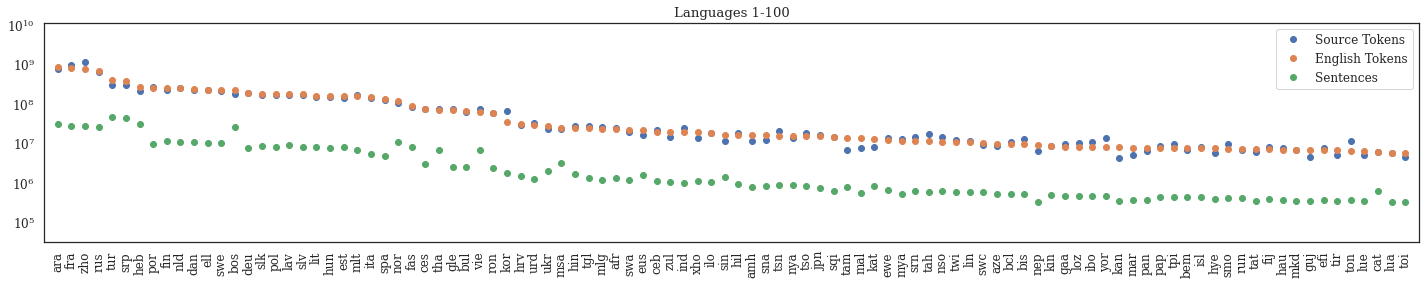

saving to lang-stats-101.pdf


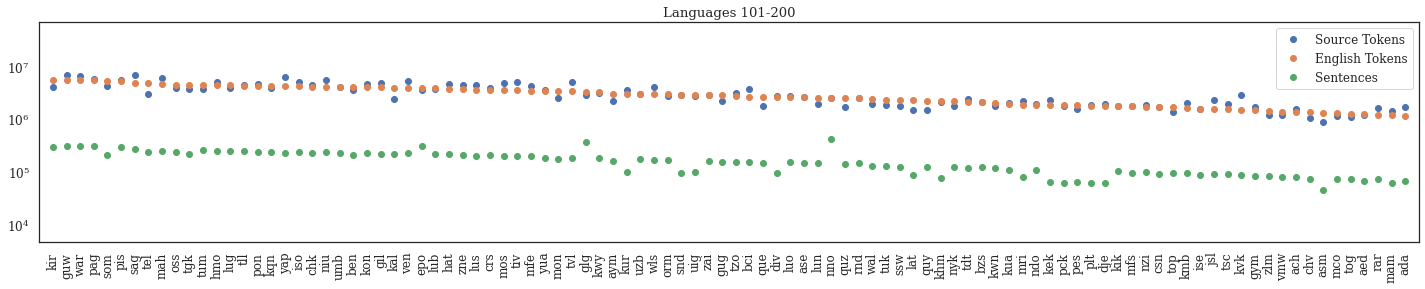

saving to lang-stats-201.pdf


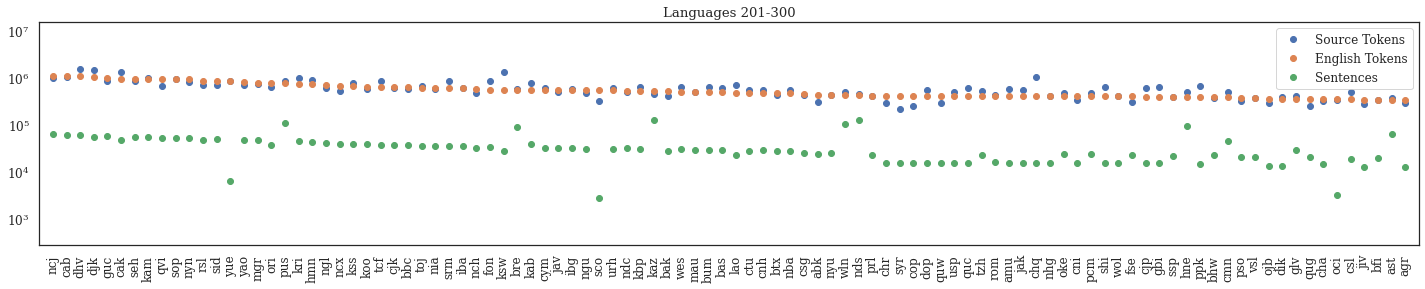

saving to lang-stats-301.pdf


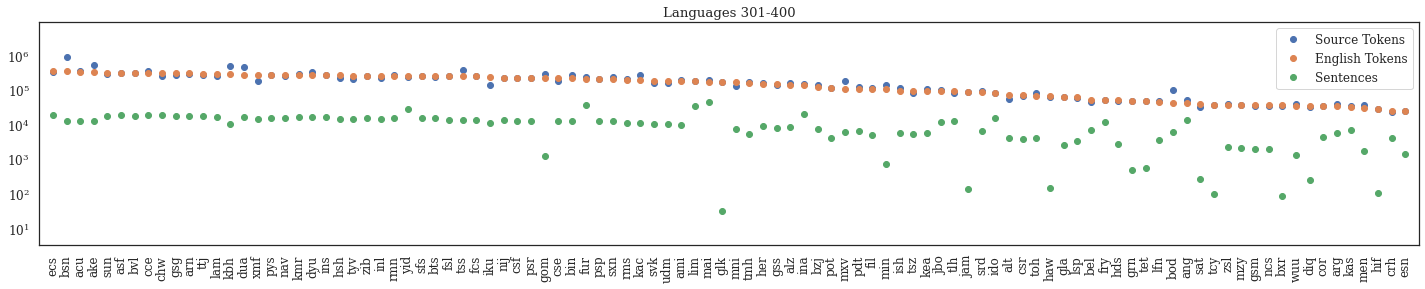

saving to lang-stats-401.pdf


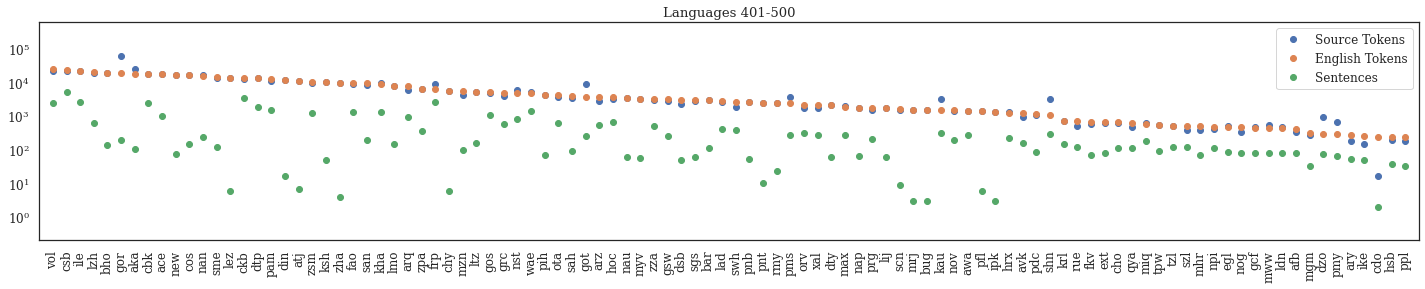

In [128]:
chunk_size=100
for start in range(0, min(500, len(lang_stat)), chunk_size):
    names = list(sorted(lang_stat.keys(), reverse=True, key=lambda l:lang_stat[l][2]))[start:start+chunk_size]
    sents = [lang_stat[n][0] for n in names]
    src_toks = [lang_stat[n][1] for n in names]
    eng_toks = [lang_stat[n][2] for n in names]

    sns.set(font="Serif", style='white',font_scale=1.1)
    simple_plot(names, series=[src_toks, eng_toks, sents], 
                legends=['Source Tokens', 'English Tokens', 'Sentences'],
                title=f'Languages {start+1}-{start+len(names)}',
               save=f'lang-stats-{start+1}.pdf')

In [130]:
print(f"Languages: {len(lang_stat)}")
print(f"Sentences: {sum(x[0] for x in lang_stat.values()):,}")
print(f"Source toks: {sum(x[1] for x in lang_stat.values()):,}")
print(f"English toks: {sum(x[2] for x in lang_stat.values()):,}")

Languages: 570
Sentences: 512,284,615
Source toks: 9,465,836,632
English toks: 9,469,695,317


# Deduplicate 



In [133]:
%%time
tok_good_file = 'merged/train.good.tok.tsv'
dedup_file = 'merged/train.good.dedup.tok.tsv'

def row_to_tsv(row):
    return f'{row.lang}\t{row.ds_name}\t{row.src}\t{row.eng}'

print(f"Deduping {tok_good_file} ->  {dedup_file}")
spark.read.csv(tok_good_file, sep='\t', schema='lang STRING, ds_name STRING, src STRING, eng STRING')\
    .dropDuplicates(['src', 'eng'])\
    .rdd.map(row_to_tsv)\
    .saveAsTextFile(dedup_file)
print("Done")

Deduping merged/train.good.tok.tsv ->  merged/train.good.dedup.tok.tsv
Done
CPU times: user 94.5 ms, sys: 75.7 ms, total: 170 ms
Wall time: 9min 50s


In [20]:
dedup_file = 'merged/train.good.dedup.tok.tsv'
SCHEMA = 'lang STRING, ds_name STRING, src STRING, eng STRING'
df_tok_dedup = spark.read.csv(dedup_file, sep='\t', schema=SCHEMA)

In [6]:
df_tok_dedup.count()

398114006

In [15]:
# check if test pairs are accidentally got into train

def tok_file(inp, out, tokr):
    log.info(f"TOK --> {out}")
    with out.open('w', encoding='utf-8', errors='ignore') as wrt, \
                  inp.open(encoding='utf-8', errors='ignore') as rdr:
        for line in rdr:
            wrt.write(tokr(line.strip()))
            wrt.write('\n')

tests_tok = []
for eng in Path('merged/tests').glob("*.eng"):
    src_name = eng.name.replace(".eng", "").split("-")[-1].split("_")[0]
    src = eng.with_suffix("."+src_name)
    assert src.exists()
    src_tok = src.with_suffix(src.suffix + '.tok')
    eng_tok = eng.with_suffix(eng.suffix + '.tok')
    tests_tok.append((src_tok, eng_tok))
    if not src_tok.exists():
        tok_file(src, src_tok, tokr=tokenize_src)
    if not eng_tok.exists():
        tok_file(eng, eng_tok, tokr=tokenize_eng)    
    
log.info(f"Found {len(tests_tok)} held out sets")


INFO:root:Found 52 held out sets


In [17]:
from itertools import zip_longest

held_out_pairs = set()
for src_tok, eng_tok in tests_tok:
    with src_tok.open() as srcs, eng_tok.open() as engs:
        for s, e in zip_longest(srcs, engs):
            assert s and e
            held_out_pairs.add((s.strip(), e.strip()))
log.info(f"Found {len(held_out_pairs):,} held out pairs")

INFO:root:Found 117,619 held out pairs


In [18]:
next(iter(held_out_pairs))

('ويلي دي ، چې دوو شعرونو يې د مور د ورځې لومړۍ درجه جايزه هم تر لاسه کړې ده .',
 'Said that his two poems of mother day achieved two first class awards .')

In [23]:
# check if there are any held out pairs in training data (who knows! we didnt create these datasets)
df_tok_dedup.rdd.filter(lambda r: (r.src.strip(), r.eng.strip()) in held_out_pairs ).count()

4435

In [25]:
matched = df_tok_dedup.rdd.filter(lambda r: (r.src.strip(), r.eng.strip()) in held_out_pairs )
from pyspark.sql.functions import rand 
matched.toDF().orderBy(rand()).take(10)

[Row(lang='ben', ds_name='JoshuaIndianCorpus_training-ben_eng', src='বিষয়শ্রেণী : যৌনতা', eng='Subject Class : Sex'),
 Row(lang='zho', ds_name='OPUS_UNPC_v1_0-zho_eng', src='评 价 结 果', eng='Evaluation results'),
 Row(lang='rus', ds_name='OPUS_UNPC_v1_0-rus_eng', src='Имена и фамилии всех лиц , обращающихся с просьбой о выдаче визы , сверяются со списком оповещений до принятия любого решения о выдаче визы на въезд в Австралию .', eng='The names of all visa applicants are checked against the List prior to any decision to grant a visa to enter Australia .'),
 Row(lang='kaz', ds_name='news_commentary_v14-kaz_eng', src='Бірнеше айдан соң болған кездесуде Трамп Ердоғанға өзін мақтағаны үшін алғыс айтты .', eng='Trump returned the compliment when he met Erdoğan a few months later .'),
 Row(lang='ara', ds_name='OPUS_UNPC_v1_0-ara_eng', src='سابعا - الرسائل والمعلومات المتعلقة بالإجراءات المتخذة عملا بأحكام المحكمة وقراراتها', eng='Communications and information concerning action taken pursuant

In [26]:
# exclude held out pairs and save it 
def row_to_tsv(row):
    return f'{row.lang}\t{row.ds_name}\t{row.src}\t{row.eng}'

dedup_notest_file = 'merged/train.good.dedup.notest.tok.tsv'
(df_tok_dedup.rdd
     .filter(lambda r: (r.src.strip(), r.eng.strip()) not in held_out_pairs )
    .map(row_to_tsv)
    .saveAsTextFile(dedup_notest_file)
)

In [27]:
# check how many we have
spark.read.csv(dedup_notest_file, sep='\t', schema=SCHEMA).count()

398109571

In [7]:
dedup_notest_file = 'merged/train.good.dedup.notest.tok.tsv'

lang_stat  = (spark.read.csv(dedup_notest_file, sep='\t', schema=SCHEMA).rdd
              .map(lambda r: (r.lang, (1, len(r.src.split()), len(r.eng.split())) ) )
              .reduceByKey(lambda a, b: tuple(x + y for x,y in zip(a, b)))   # merge
              .collectAsMap())

In [11]:
print(list(lang_stat.items())[:5])

[('iso', (218950, 4969379, 4090841)), ('sid', (46824, 687070, 847650)), ('ike', (49, 150, 258)), ('aln', (27, 137, 138)), ('lad', (385, 2261, 2484))]


In [13]:
stats_file = Path('lang-stats-tok-dedup.tsv')
with stats_file.open('w') as f:
    f.write("\t".join(["Lang", "Sents", "Source", "English"]) + '\n')
    for lang in sorted(lang_stat):
        sents, src_toks, eng_toks = lang_stat[lang]
        f.write(f"{lang}\t{sents}\t{src_toks}\t{eng_toks}\n")
    print(f"Wrote {stats_file}")

Wrote lang-stats-tok-dedup.tsv


saving to stats-dedup-1.pdf


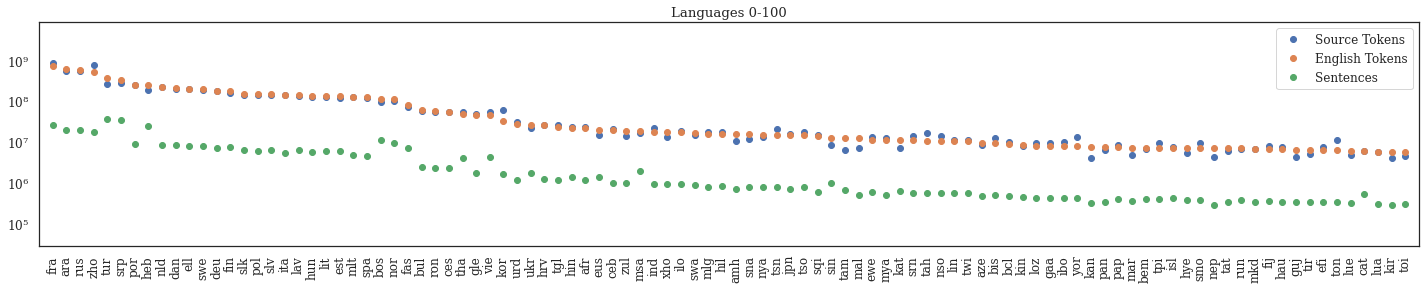

saving to stats-dedup-101.pdf


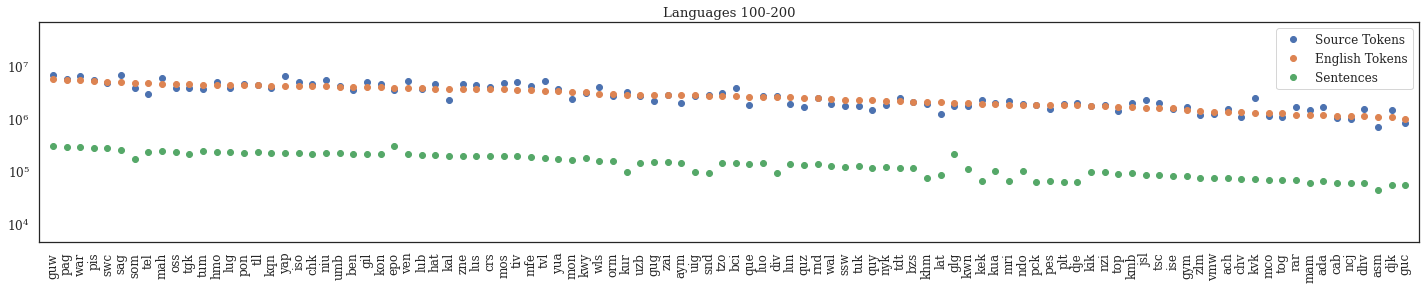

saving to stats-dedup-201.pdf


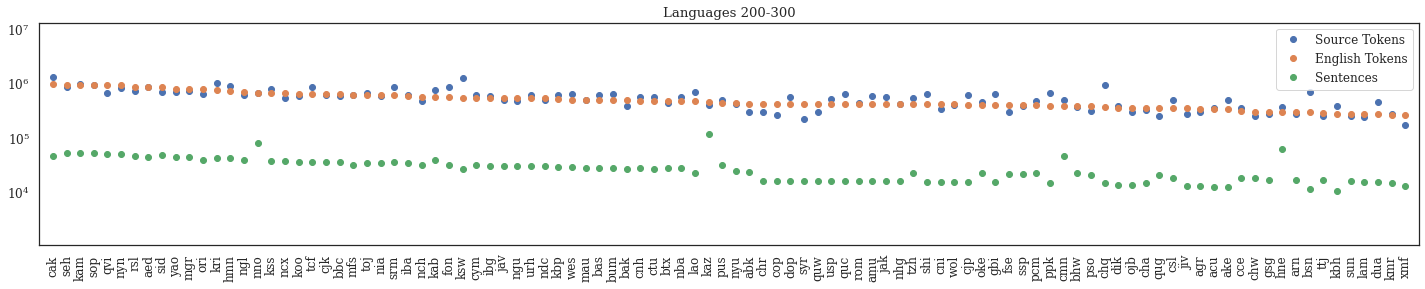

saving to stats-dedup-301.pdf


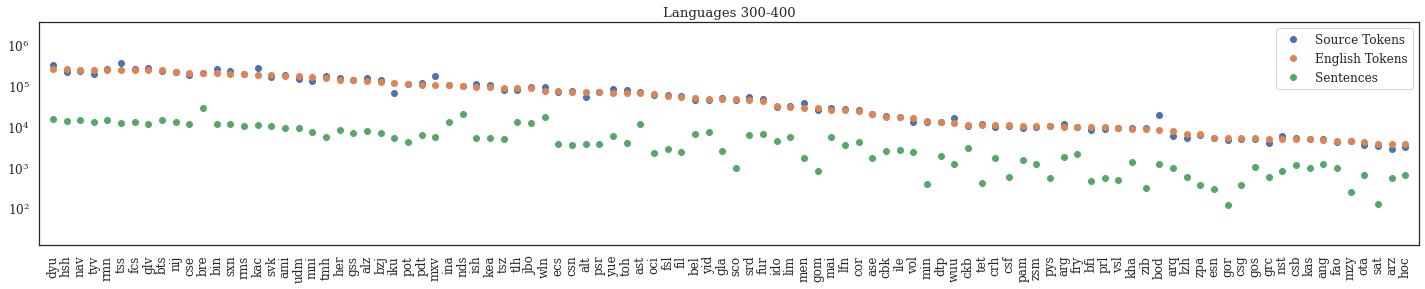

saving to stats-dedup-401.pdf


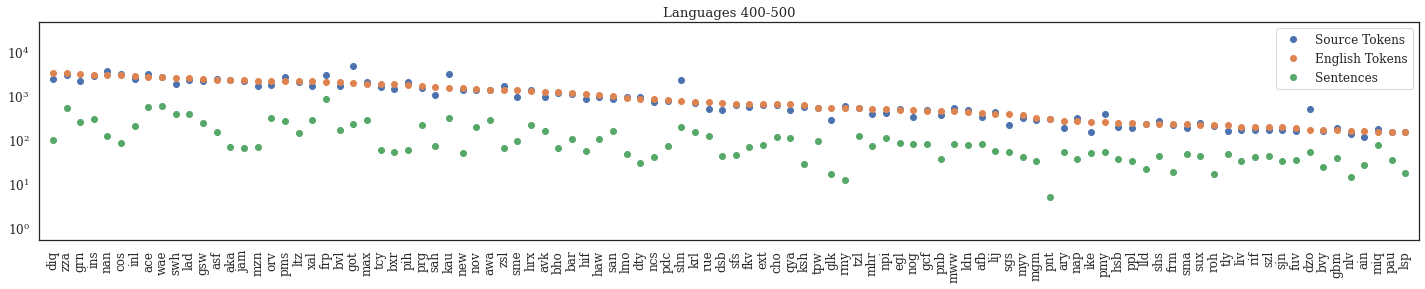

In [19]:
plot_lang_stats(lang_stat, saveas='stats-dedup.pdf')

In [21]:
sums = [0, 0, 0]
for it in lang_stat.values():
    sums[0] += it[0]
    sums[1] += it[1]
    sums[2] += it[2]
print(f'Languages: {len(lang_stat)}')
print(f'Sentences: {sums[0]:,}')
print(f'Source Toks: {sums[1]:,}')
print(f'English Toks: {sums[2]:,}')

Languages: 563
Sentences: 398,109,571
Source Toks: 7,884,892,582
English Toks: 7,930,948,857


---
# Selection

Select top languages; exclude extreme low resource languages

Top is based on number of parallel sentences or tokens 

It would be nice to see what are top languages based on number of speakers. 

https://store.ethnologue.com/2019-ethnologue-200 has a list, but its $250 to obtain it. 



In [29]:
ranked_stats = sorted(lang_stat.items(), key=lambda x: x[1][-1], reverse=1)
for rank, (lang, (sents, src, eng)) in enumerate(ranked_stats, start=1):
    print(f'{rank}\t{lang}\t{sents:,}\t{src:,}\t{eng:,}')
    if src  < 100_000 or eng < 100_000:
        break

1	fra	26,294,210	851,304,061	727,106,230
2	ara	19,986,856	543,817,292	622,205,409
3	rus	19,797,813	543,017,335	575,341,274
4	zho	17,287,870	745,125,897	508,821,873
5	tur	36,840,644	262,006,806	362,782,398
6	srp	34,767,718	269,487,590	333,491,622
7	por	8,698,865	244,795,908	241,691,367
8	heb	24,059,128	189,051,405	241,286,053
9	nld	8,521,257	215,477,664	216,999,244
10	dan	8,279,106	199,642,863	203,962,773
11	ell	7,890,356	196,300,234	199,075,216
12	swe	8,143,677	188,049,760	194,164,857
13	deu	7,118,195	175,961,161	179,195,097
14	fin	7,546,211	156,934,425	171,751,873
15	slk	6,361,092	144,263,011	150,846,817
16	pol	6,008,316	140,966,403	147,122,485
17	slv	6,142,856	141,366,773	147,055,653
18	ita	5,205,634	138,712,500	144,358,869
19	lav	6,247,727	133,482,419	141,346,139
20	hun	5,782,578	128,594,047	135,122,403
21	lit	5,890,566	127,264,615	135,011,884
22	est	5,855,307	118,500,082	129,467,035
23	mlt	4,781,062	128,670,288	127,060,790
24	spa	4,606,307	120,315,291	125,267,879
25	bos	11,136,988	

**Top 200 languages have 1M or more english tokens, So we shall select those**

In [ ]:
top200 = [x[0] for x in ranked_stats[:200]]
top200[:5], top200[-5:]
top200 = set(top200)

In [ ]:
def row_to_tsv(row):
    return f'{row.lang}\t{row.ds_name}\t{row.src}\t{row.eng}'

dedup_notest_file = 'merged/train.good.dedup.notest.tok.tsv'
top200_file = 'merged/train.good.dedup.notest.top200.tok.tsv'

(spark.read.csv(dedup_notest_file, sep='\t', schema=SCHEMA).rdd
    .filter(lambda r: r.lang in top_200)
    .map(row_to_tsv)
    .saveAsTextFile(top200_file)
)
print("done")

In [1]:
# Collect the rows as separate plain text file -- 

In [ ]:
top200_tsv = 'merged/train.good.dedup.notest.top200.tok.tsv'
rdd = spark.read.csv(top200_tsv, sep='\t', schema=SCHEMA).rdd
from tqdm.auto import tqdm

top200_src = 'merged/train.good.dedup.notest.top200.src.tok'
top200_eng = 'merged/train.good.dedup.notest.top200.eng.tok'
top200_meta = 'merged/train.good.dedup.notest.top200.meta'
args = dict(mode='w', errors='ignore', encoding='utf-8')
with open(top200_src, **args) as src,\
        open(top200_eng, **args) as eng,\
        open(top200_meta, **args) as meta:
    for row in tqdm(rdd.toLocalIterator()):
        src.write(f'{row.src}\n')
        eng.write(f'{row.eng}\n')
        meta.write(f'{row.lang}\t{row.ds_name}\n')

log.info("Done")

In [5]:
SCHEMA

'lang STRING, ds_name STRING, src STRING, eng STRING'